# $C_\ell$ and $\mathcal{R}_\ell^{TE}$ simulations results

In [1]:
import getdist.plots as gdplt
import matplotlib as mpl
from getdist.mcsamples import loadMCSamples
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def pars_from_str(p, name):
    return(getattr(p, name))

In [3]:
def get_lim_dict(sample_list, wanted):
    par_dict = {}
    lim_dict = {}
    for parameter in wanted:
        par_dict[parameter] = []

        for i, sample in enumerate(sample_list):
            p = sample.getParams()
            par_dict[parameter] = np.concatenate((
                                  par_dict[parameter],
                                  pars_from_str(p, parameter))
                                  )
        lim_dict[parameter] = [np.min(par_dict[parameter]), np.max(par_dict[parameter])]
    return(lim_dict)

def get_maxpost_dict(sample_list, wanted):
    lim_dict = get_lim_dict(sample_list, wanted)
    maxpost_dict = {}
    sigma_dict = {}
    for parameter in wanted:
        x = np.linspace(lim_dict[parameter][0], lim_dict[parameter][1], 2500)
        prob = [s.get1DDensity(parameter).Prob(x) for s in sample_list]
        upper_bound = [s.get1DDensity(parameter).getLimits(0.68)[1] for s in sample_list]
        upper_bound = np.array(upper_bound)
        maxprob = [np.argmax(element) for element in prob]
        maxprobpar = [x[element] for element in maxprob]
        maxpost_dict[parameter] = np.array(maxprobpar)
        sigma_dict[parameter] = upper_bound - np.array(maxprobpar)
    return(maxpost_dict, sigma_dict)

def get_distribs_dict(sample_list, wanted):
    lim_dict = get_lim_dict(sample_list, wanted)
    distrib_dict = {}
    for parameter in wanted:
        x = np.linspace(lim_dict[parameter][0], lim_dict[parameter][1], 25000)
        prob = [s.get1DDensity(parameter).Prob(x) for s in sample_list]
        distrib_dict[parameter] = [x, prob]
        
    return(distrib_dict)

def gauss(x,mu,sig):
    return(np.exp(-0.5 * (x-mu)**2 / sig ** 2))

In [4]:
def check_consistency(sample , wanted, true, nrow, ncol):

    fig = plt.figure(figsize = (ncol*3.7, nrow*3.7))
    
    maxpost_dict, sigma_dict = get_maxpost_dict(sample, wanted)
    dist_dict = get_distribs_dict(sample, wanted)
    
    #for i, key in enumerate(maxpost_dict):
        #print(key)
        #print("-"*len(key))
        #print("  mean : ", np.mean(maxpost_dict[key]))
        
    for i, key in enumerate(maxpost_dict):
        ax = fig.add_subplot(100 * nrow + 10 * ncol + 1 + i)

        mean = np.mean(maxpost_dict[key])
        cov = np.std(maxpost_dict[key])
        
        cov_bis = np.mean(sigma_dict[key])
        rcov = cov_bis / np.sqrt(len(maxpost_dict[key]))
        
        Ns = (mean - true[i]) / rcov
        Ns = round(Ns, 2)
        vmin = true[i] - 5 * cov_bis
        vmax = true[i] + 5 * cov_bis
        
        x = np.linspace(vmin, vmax, 150)
        #gaus = gauss(x, mean, cov)
        gaus_bis = gauss(x, mean, cov_bis)
        #print(key + " SNR : ", true[i]/cov)

        #ax.plot(x, gaus, color = 'darkblue', lw = 3, zorder = 5, label = r'$\frac{%s\sigma}{\sqrt{N_{sim}}}$' % str(Ns))
        ax.plot(x, gaus_bis, color = 'darkblue', lw=3, zorder = 5)
        x, distr = dist_dict[key]
        
        for dis in distr:
            ax.plot(x, dis, color = 'gray', alpha = 0.7)
    
        ax.axvline(true[i], ymin = -2, ymax = +2, ls = '--', color = 'k', lw = 2)
        ax.set_xlabel(latex[key], fontsize = 15)
        #ax.legend(fontsize = 15, loc = "upper right")
        ax.annotate(r'$\frac{%s\sigma}{\sqrt{N_{sim}}}$' % str(Ns), xy =(0.75,0.87), xycoords='axes fraction', fontsize = 15)
        #ax.set_xlim(true[i] - 5 * cov, true[i] + 5 * cov)
        #ax.grid(True, ls = 'dotted')

    plt.tight_layout()
    plt.show()

In [5]:
latex = {'cosmomc_theta': r"$\theta_\mathrm{MC}$",
         'ombh2': r"$\Omega_bh^2$",
         'omch2': r"$\Omega_ch^2$",
         'logA': r"$\mathrm{ln}(10^{10}A_\mathrm{s})$",
         'ns': r"$n_\mathrm{s}$",
         'tau': r"$\tau$",
         'H0': r"$H_0$",
         'AdustPP': r"$A_{dust}^{PP}$",
         'AdustTP': r"$A_{dust}^{TP}$",
         'Aradio': 'Aradio',
         'Adusty': 'Adusty',
         'AdustTT': 'AdustTT',
         'Asz': 'Asz',
         'Aksz': 'Aksz',
         'Aszxcib': 'Aszxcib',
         'Acib': 'Acib'
         }

cosmo = ['cosmomc_theta', 'ombh2', 'omch2', 'logA', 'ns', 'tau']
fg = ['Aradio', 'Adusty', 'AdustTT', 'AdustTP', 'AdustPP', 'Asz', 'Acib', 'Aksz', 'Aszxcib']
true_cosmo = [0.0104057, 0.022142, 0.1201, np.log(pow(10,10) * 2.0929e-9), 0.9616, 0.0566]
true_fg = [1.658,0.628,0.908,1.051,1.045,1.129, 0.989, 0.031, 1.46]

In [6]:
samples_TTTEEE = []
samples_TTTEEE_bias = []
samples_TTTEEE_bias_check = []
samples_RTE_hpriors = []
samples_RTE = []

for i in range(0, 20):
    data_dir_TTTEEE = "../sim_results/TTTEEE/sim{}/mcmc".format(i)
    data_dir_TTTEEE_bias = "../sim_results/TTTEEE_bias/sim{}/mcmc".format(i)
    data_dir_RTE_hpriors = "../sim_results/RTE_hpriors/sim{}/mcmc".format(i)
    data_dir_RTE = "../sim_results/RTE/sim{}/mcmc".format(i)
    
    samples_TTTEEE.append(loadMCSamples(data_dir_TTTEEE, settings = {'ignore_rows': 0.5}))
    samples_TTTEEE_bias.append(loadMCSamples(data_dir_TTTEEE_bias, settings = {'ignore_rows': 0.5}))
    samples_RTE_hpriors.append(loadMCSamples(data_dir_RTE_hpriors, settings = {'ignore_rows': 0.5}))
    samples_RTE.append(loadMCSamples(data_dir_RTE, settings = {'ignore_rows': 0.5}))
    
for i in range(0, 10):
    data_dir_TTTEEE_bias_check = "../sim_results/TTTEEE_bias_check/sim{}/mcmc".format(i)
    samples_TTTEEE_bias_check.append(loadMCSamples(data_dir_TTTEEE_bias_check, settings = {'ignore_rows': 0.5}))

### Consistency of $C_\ell$ sims

Use of hillipop default priors with flat priors for $A_{\mathrm{kSZ}}$ and $A_{\mathrm{sz}\times\mathrm{cib}}$. The figure displays the results for $N_{sim} = 20$

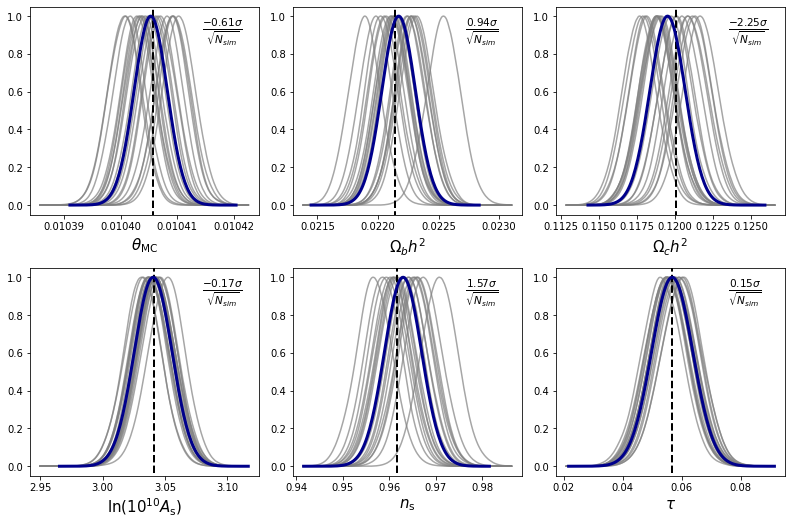

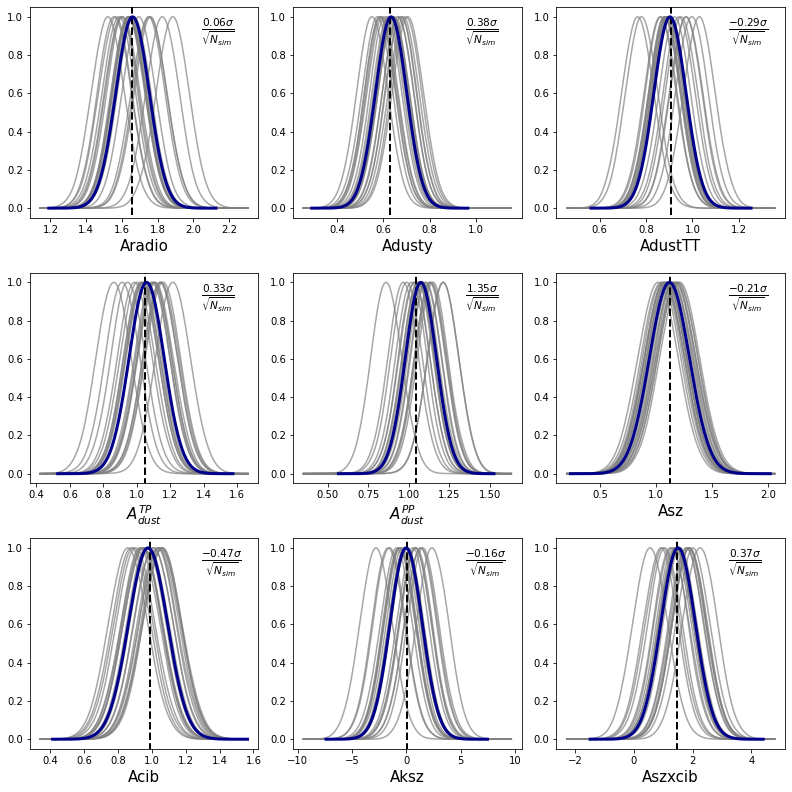

In [7]:
check_consistency(samples_TTTEEE, cosmo, true_cosmo, 2, 3)
check_consistency(samples_TTTEEE, fg, true_fg, 3, 3)

### Consistency of $\mathcal{R}_\ell$ sims

Use of hillipop default priors for foregrounds (with [0,10] flat priors for $A_{\mathrm{kSZ}}$ and $A_{\mathrm{sz}\times\mathrm{cib}}$). The foregrounds posterior distributions shows a very poor constraining power from $\mathcal{R}_\ell^{TE}$. The figure displays the results for $N_{sim} = 20$

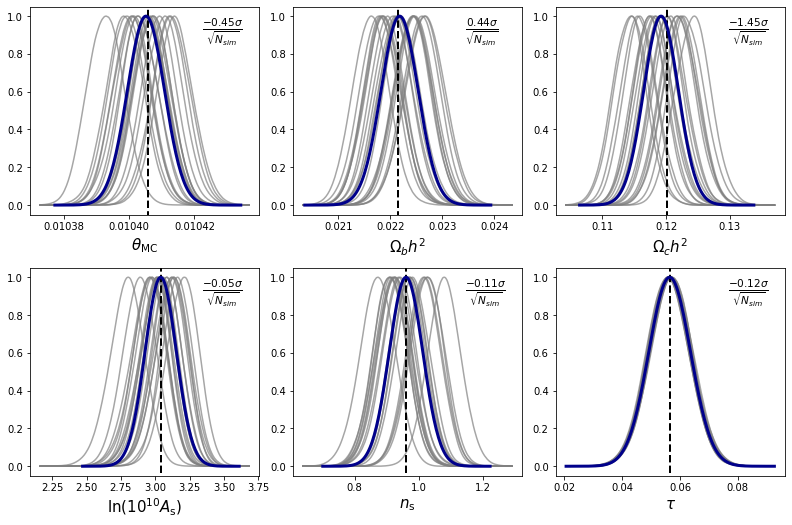

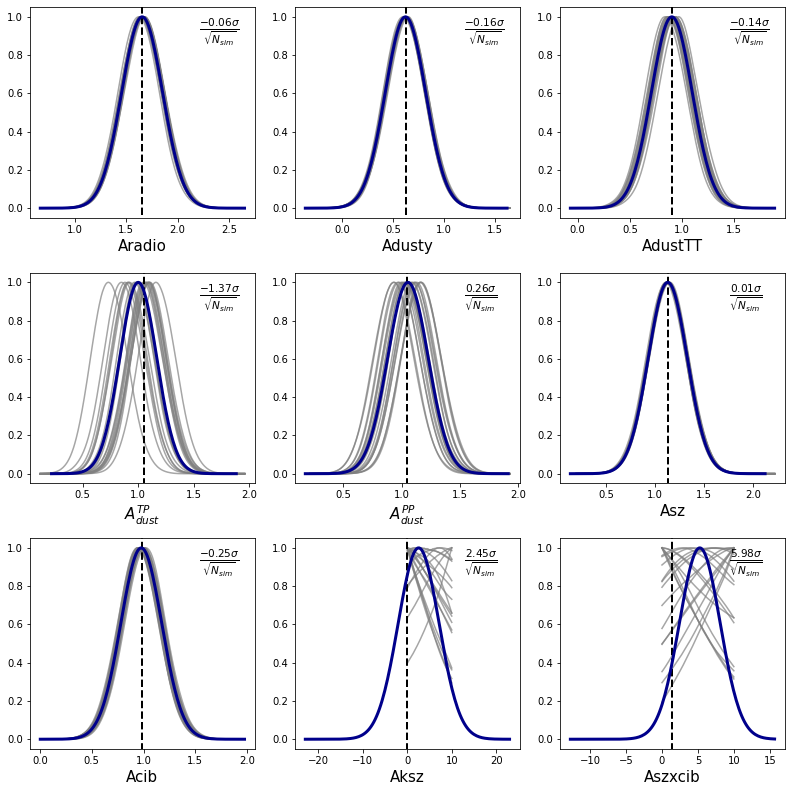

In [8]:
check_consistency(samples_RTE_hpriors, cosmo, true_cosmo, 2, 3)
check_consistency(samples_RTE_hpriors, fg, true_fg, 3, 3)

### Polarization transfer function applied on $C_\ell$ sims

The red line is a distribution of the shift in parameters when we add a polarization transfer function.

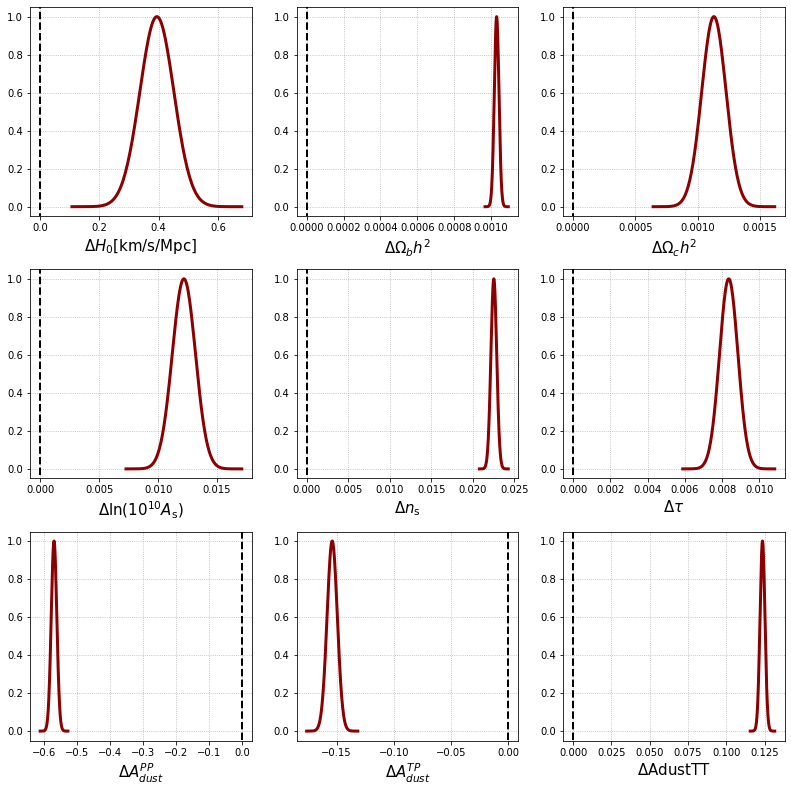

In [9]:
wanted = ['H0', 'ombh2', 'omch2', 'logA', 'ns', 'tau', 'AdustPP', 'AdustTP', 'AdustTT']
maxpost_cl, sigma_cl = get_maxpost_dict(samples_TTTEEE, wanted)
maxpost_cltf, sigma_cltf = get_maxpost_dict(samples_TTTEEE_bias, wanted)

diff_dict = {}

fig = plt.figure(figsize = (3*3.7, 3*3.7))

for i, key in enumerate(maxpost_cltf):
    
    ax = fig.add_subplot(331 + i)
    diff_dict[key] = maxpost_cltf[key] - maxpost_cl[key]
    
    mean = np.mean(diff_dict[key])
    cov = np.std(diff_dict[key])
    
    rcov = np.std(diff_dict[key]) / np.sqrt(len(diff_dict[key]))
    nsig = mean / rcov
    #print("Bias on {} : {} sigma".format(key, nsig))
    
    meantf = np.mean(maxpost_cltf[key])
    covtf = np.std(maxpost_cltf[key])
    meancl = np.mean(maxpost_cl[key])
    covcl = np.std(maxpost_cl[key])
    import matplotlib.pyplot as plt
    min = mean - 5 * cov
    max = mean + 5 * cov
    mintf = meantf - 5*covtf
    maxtf = meantf + 5*covtf
    mincl = meancl - 5*covcl
    maxcl = meancl +5*covcl
    x = np.linspace(min, max, 150)
    gaus = gauss(x, mean, cov)
    ax.plot(x, gaus, color = 'darkred', lw = 3)
    ax.axvline(0, ymin=-2, ymax=+2, ls = '--', color ='k', lw = 2)
    ax.grid(True, ls = 'dotted')
    if latex[key] == r"$H_0$":
        ax.set_xlabel(r'$\Delta$' + latex[key] + r"$[\mathrm{km}/\mathrm{s}/\mathrm{Mpc}]$", fontsize = 15)
    else:
        ax.set_xlabel(r'$\Delta$' + latex[key], fontsize = 15)
plt.tight_layout()
plt.show()

## Covariance between parameters

In this cell, we investigate the bias induced by using $\mathcal{R}_\ell^{TE}$ to constrain cosmology. The figure displays the mean value and standard deviation for $\Delta\theta = \theta^{\mathcal{R}_\ell} - \theta^{C_\ell}$

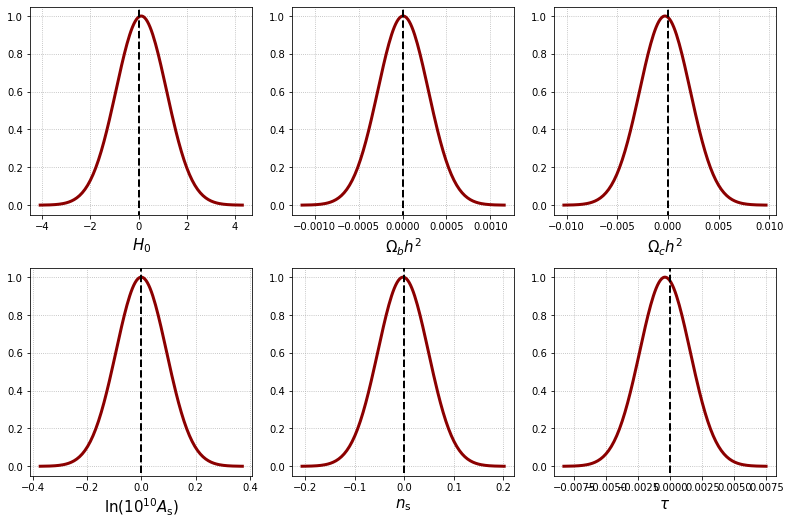

In [10]:
wanted = ['H0', 'ombh2', 'omch2', 'logA', 'ns', 'tau']
maxpost_cl, sigma_cl = get_maxpost_dict(samples_TTTEEE, wanted)
maxpost_rte, sigma_rte = get_maxpost_dict(samples_RTE_hpriors, wanted)

diff_dict = {}
fig = plt.figure(figsize = (3*3.7, 2*3.7))
for i, key in enumerate(maxpost_rte):
    ax = fig.add_subplot(231 + i)
    diff_dict[key] = maxpost_rte[key] - maxpost_cl[key]
    hist, bins = np.histogram(diff_dict[key])
    bins = [np.mean(bins[i:i+2]) for i in range(len(bins) - 1)]
    hist = hist / np.max(hist)
    #print(diff_dict[key])
    #print(key)
    mean = np.mean(diff_dict[key])
    cov = np.std(diff_dict[key]) 
    rcov = np.std(diff_dict[key]) / np.sqrt(len(diff_dict[key]))
    nsig = mean / rcov
    #print("Bias on {} : {} sigma".format(key, nsig))
    import matplotlib.pyplot as plt
    vmin = mean - 4 * cov
    vmax = mean + 4 * cov
    x = np.linspace(vmin, vmax, 150)
    gaus = gauss(x, mean, cov)
    ax.plot(x, gaus, color = 'darkred', lw = 3)
    #ax.plot(bins, hist, color = 'tab:blue', lw = 2)
    ax.axvline(0, ymin=-2, ymax=+2, ls = '--', color ='k', lw = 2)
    #ax.axvline(param[i], ymin=-2, ymax=+2, color = 'r', lw = 2)
    ax.grid(True, ls = 'dotted')
    ax.set_xlabel(latex[key], fontsize = 15)

plt.tight_layout()
plt.show()

In this cell we compute the difference between max-posteriors from $\mathcal{R}_\ell^{TE}$ and from $C_\ell$s for each simulations in order to compare $\sigma(\theta^{\mathcal{R}_\ell^{TE}} - \theta^{C_\ell})$ with the width of $\mathcal{R}_\ell^{TE}$ (or $C_\ell$)-derived posterior distributions. The goal is to show that the shift in parameters induced by using the correlation coefficient is ~ $\sigma(\theta^{\mathcal{R}_\ell^{TE}})$

<ipython-input-11-e95cc86dc1b2>:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1,l2,l3], labels=labels, fontsize = 15, loc = 'upper center', ncol = 3)


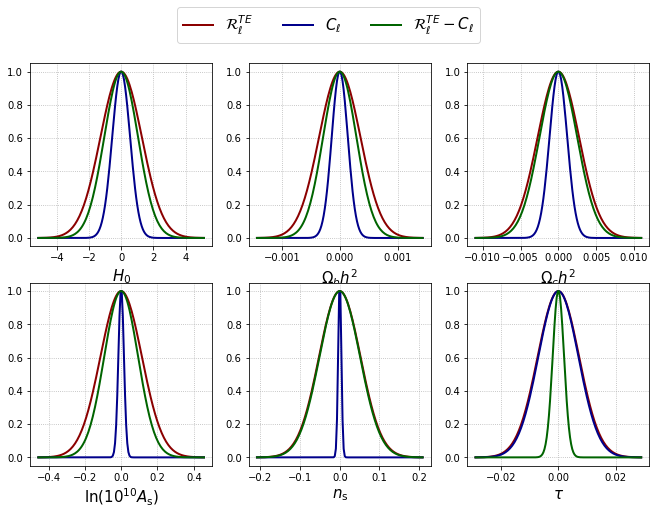

In [11]:
labels = [r"$\mathcal{R}_\ell^{TE}$", r"$C_\ell$", r"$\mathcal{R}_\ell^{TE} - C_\ell$"]
fig = plt.figure(figsize = (3*3.7, 2*3.7))
for i, key in enumerate(maxpost_cl):
    
    ax = fig.add_subplot(231 + i)
    #covC = np.std(maxpost_cl[key])
    covC = np.mean(sigma_cl[key])
    #covR = np.std(maxpost_rte[key])
    covR = np.mean(sigma_rte[key])
    covdiff = np.std(diff_dict[key])
    meandiff = np.mean(diff_dict[key])
    
    vmin = - 4 * covR
    vmax = 4 * covR
    x = np.linspace(vmin, vmax, 150)
    gausR = gauss(x, 0, covR)
    gausC = gauss(x, 0, covC)
    gausdiff = gauss(x, 0, covdiff)
    l1 =ax.plot(x, gausR/np.max(gausR), color = 'darkred', lw = 2, label = r"$\mathcal{R}_\ell^{TE}$")
    l2 = ax.plot(x, gausC/np.max(gausC), color = 'darkblue', lw = 2, label = r"$C_\ell$")
    l3 = ax.plot(x, gausdiff/np.max(gausdiff), color = 'darkgreen', lw = 2, label = r"$\mathcal{R}_\ell^{TE} - C_\ell$")
    #ax.plot(bins, hist, color = 'tab:blue', lw = 2)
    #ax.axvline(0, ymin=-2, ymax=+2, ls = '--', color ='k', lw = 2)
    #ax.axvline(param[i], ymin=-2, ymax=+2, color = 'r', lw = 2)
    ax.grid(True, ls = 'dotted')
    ax.set_xlabel(latex[key], fontsize = 15)
fig.legend([l1,l2,l3], labels=labels, fontsize = 15, loc = 'upper center', ncol = 3)
plt.show()